[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Gridshell_Station_Shape.ipynb)

In [ ]:
! pip install JaxSSO
! pip install trimesh
! pip install httpx

In [ ]:
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import json

/tmp/ipykernel_1497684/3875112809.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load the geometry

In [4]:
#Import the geometry, mesh and fixed node info
import urllib
f = urllib.request.urlopen('https://raw.githubusercontent.com/GaoyuanWu/JaxSSO/main/Examples/Data/Station.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)


f.close()

df = data['faces'] #Connectivity matrix
faces = np.array(df) #convert to numpy array
df2 = data['vertices'] #Coordinate
crd = np.array(df2) #convert to numpy array
df3 = data['vertex_is_red'] #Connectivity matrix
fixed_nodes = np.where(df3)[0] #convert to numpy array

#From faces to frames
import trimesh
mesh = trimesh.load_remote('https://raw.githubusercontent.com/GaoyuanWu/JaxSSO/main/Examples/Data/Station.ply')

cnct  = np.array(mesh.edges_unique)

In [5]:
#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

In [6]:
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
    design_nodes.append(i)

fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))

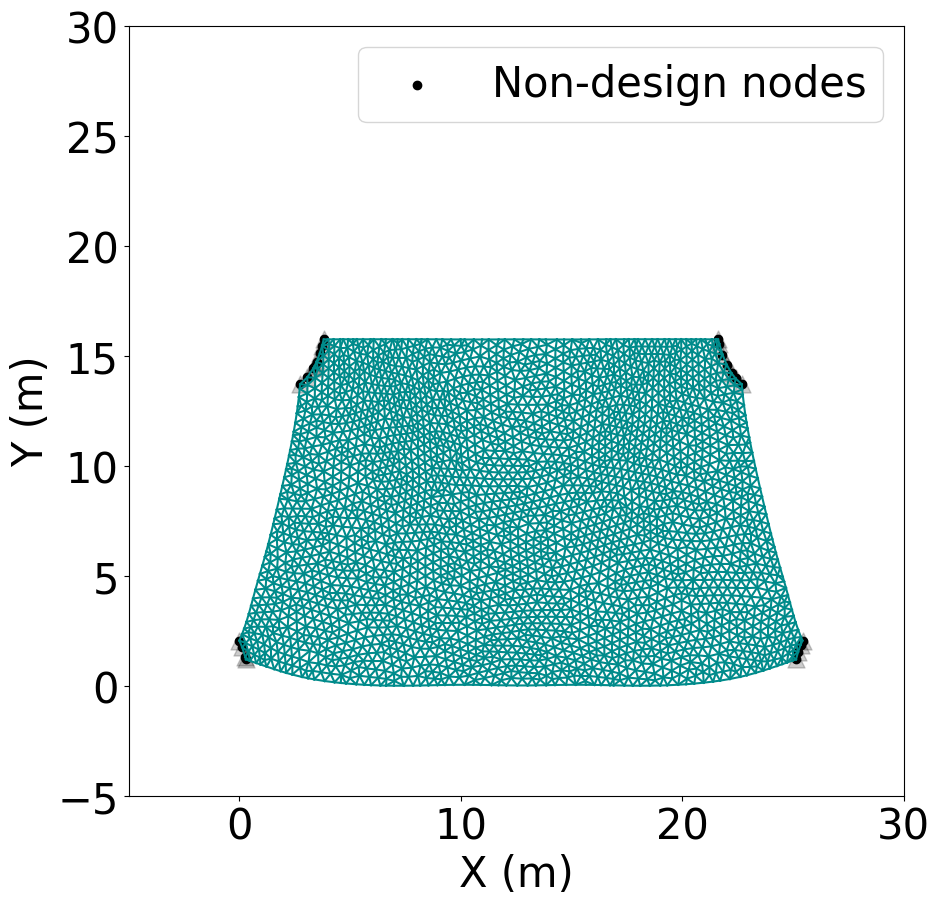

In [7]:

fig,ax = plt.subplots(figsize=(10,10))
plt.xlim(-5,30)
plt.ylim(-5,30)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')

plt.legend(fontsize=30)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

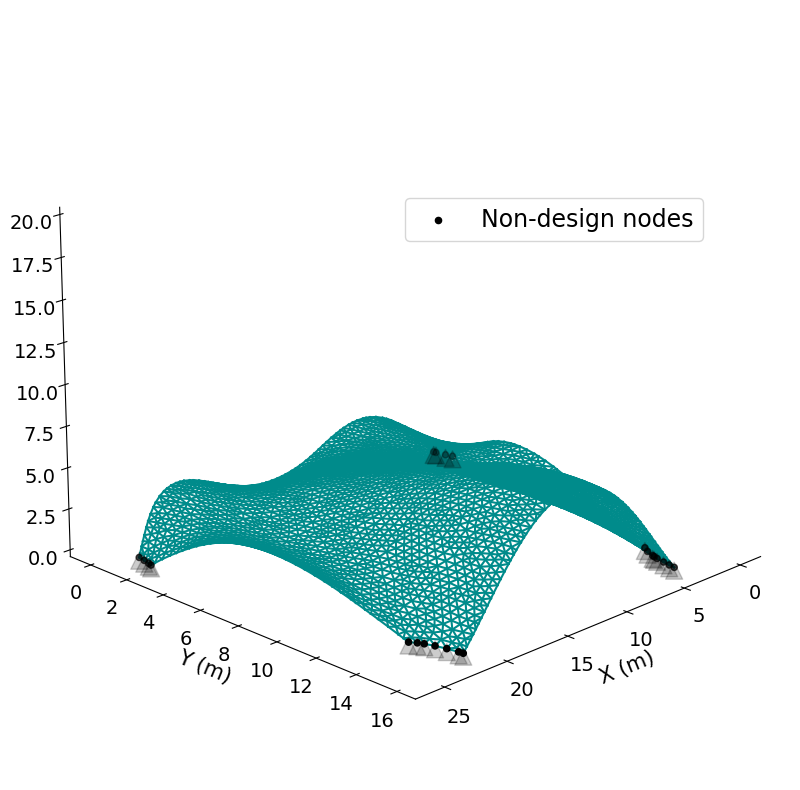

In [8]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,20)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

# Define the hat filter

In [9]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))
#Matrix storing XY-projected distance  
dx_ij = x_nodes[:,None]-x_nodes[None,:]
dy_ij = y_nodes[:,None]-y_nodes[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,4)


#This does not impose any constraints on the boundary nodes.
#We apply soft constraints - increasing the weights of boundary
alpha = 1 # coefficient adujsting the weights for boundary
B_ij_ini[:,non_design_nodes] *= alpha
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(x_nodes.shape[0]).reshape(x_nodes.shape[0],x_nodes.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [10]:
zs_filtered = z_nodes.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

# Create the FE model and SSO_model

In [11]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle
h = 0.2 #height
b = 0.1 #width
E = 37900 * 10**5 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area
load = -10 #Pt load

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 


In [12]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# Define the objective function and conduct optimization

In [14]:
C_hist = []
def objective_filter(x,sso_model=sso_model):
    p = z_nodes.copy()
    p[design_nodes]=x
    z = (B_ij@p)[design_nodes]
    sso_model.update_nodeparameter(z) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    C_hist.append(C)
    return C,np.asarray((sens@B_ij[design_nodes])[design_nodes],dtype=float)#sens_params

In [15]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = sso_model.nodeparameters_values #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective_filter) #objective function
opt.set_maxiter(150) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 322.0275890225081
Step 1, objective = 292.6575970898972
Step 2, objective = 263.4251278020331
Step 3, objective = 235.16368039324135
Step 4, objective = 208.57523148838928
Step 5, objective = 184.11549367886252
Step 6, objective = 161.98208941938657
Step 7, objective = 142.17080107150096
Step 8, objective = 124.54776527655123
Step 9, objective = 108.91206408285373
Step 10, objective = 95.03987595319659
Step 11, objective = 82.71413203538448
Step 12, objective = 71.74299329356613
Step 13, objective = 61.97080484721741
Step 14, objective = 53.28414983625006
Step 15, objective = 45.61306755408004
Step 16, objective = 38.92921345339866
Step 17, objective = 33.42695829598308
Step 18, objective = 29.052153534843075
Step 19, objective = 25.636247049928574
Step 20, objective = 22.84433732612807
Step 21, objective = 20.85300966393276
Step 22, objective = 19.48254108067734
Step 23, objective = 18.25432354342821
Step 24, objective = 17.14558158804269
Step 25, objective = 16.14

In [16]:
z_nodes[design_nodes] = x_opt
zs_filtered = z_nodes.copy()
zs_filtered[design_nodes] =(B_ij@z_nodes)[design_nodes]

# Plot the results

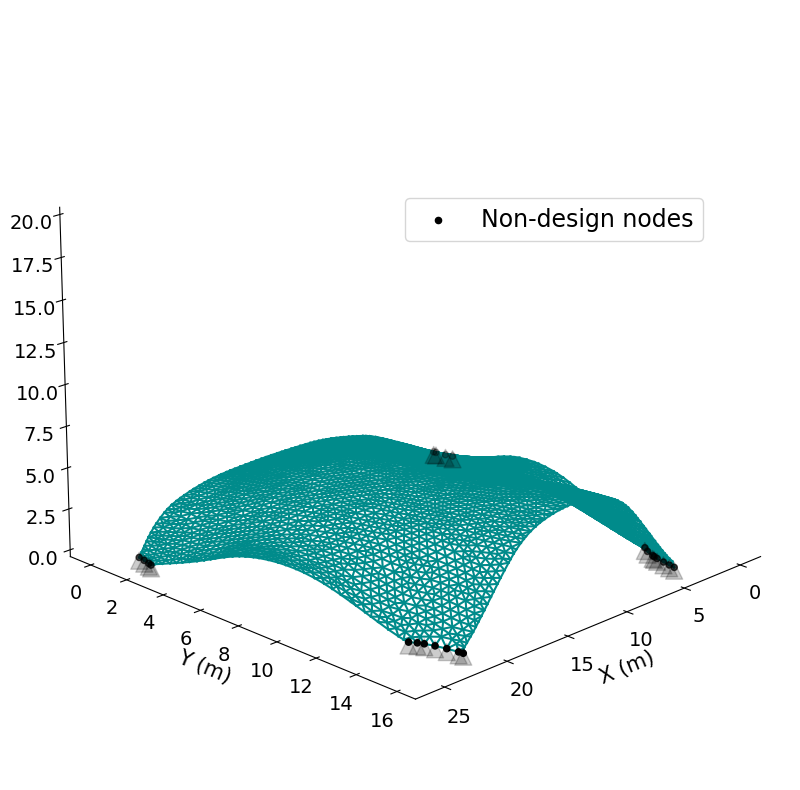

In [17]:
#Update the nodes
%matplotlib inline

z_ele[:,0] = zs_filtered[cnct[:,0]]
z_ele[:,1] = zs_filtered[cnct[:,1]]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,20)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

Text(0, 0.5, 'Total strain energy (KN$\\cdot$m)')

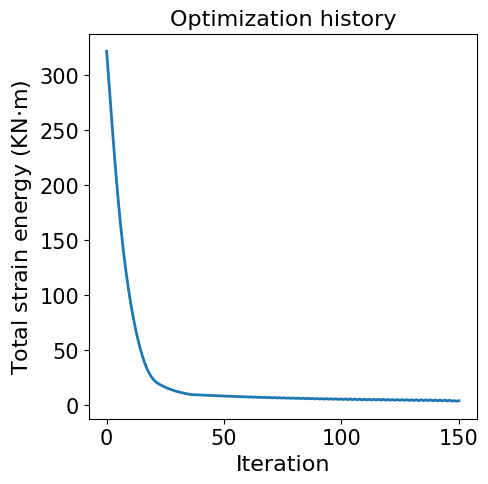

In [31]:


fig, ax = plt.subplots(figsize=(5,5))

plt.plot(np.linspace(0,150,150),np.array(C_hist),linewidth=2)
plt.xticks([0,50,100,150],fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Iteration',fontsize=16)
plt.title('Optimization history',fontsize=16)
plt.ylabel(r'Total strain energy (KN$\cdot$m)',fontsize=16)